<a href="https://colab.research.google.com/github/mtoce/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/build2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
!pip install category_encoders

In [0]:
# Read in dataframe. Shape is (8274, 29)
#df = pd.read_csv('astros_bangs_20200127.csv')
df = pd.read_csv('https://raw.githubusercontent.com/mtoce/Build2-Project/master/astros_bangs_20200127.csv')

# Define target as whether bangs were heard during batter's AB
# Bangs were used by the Astros after using technology to steal signs to signal to the batter what pitch was coming
y = 'has_bangs'

In [0]:
# Feature engineering function
def feature_engineering(X):
  '''
  Engineer new features for dataframe X.
  '''
  hit_list = ['Single', 'Double', 'Triple', 'Home Run']
  obp_list = ['Single', 'Double', 'Triple', 'Home Run', 'Walk', 'Hit By Pitch', 'Sac Fly']
  out_list = ['Strikeout', 'Double Play',
       'Grounded Into DP', 'Catcher Interference', 'Flyout', 'Groundout',
       'Lineout', 'Sac Fly', 'Fan interference', 'Pop Out',
       'Double', 'Forceout', 'Sac Bunt', 'Strikeout - DP', 'Fielders Choice Out',
       'Bunt Groundout', 'Bunt Pop Out']
  X['hit'] = X['at_bat_event'].isin(hit_list)
  X['on_base'] = X['at_bat_event'].isin(obp_list)
                                          
  return X

df = feature_engineering(df)

In [0]:
def wrangle(X):
    '''
    Wrangle function for DF before train_test_split
    '''

    X = X.copy()

    # Change game_date to a datetime for ease of use
    X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)

    # Replace some character strings with numbers
    X['has_bangs'] = X['has_bangs'].replace({'n': 0, 'y': 1})
    X['on_1b'] = X['on_1b'].replace({'t': 1, 'f': 0})
    X['on_2b'] = X['on_2b'].replace({'t': 1, 'f': 0})
    X['on_3b'] = X['on_3b'].replace({'t': 1, 'f': 0})
    X['hit'] = X['hit'].replace({True: 1, False: 0})
    X['on_base'] = X['on_base'].replace({True: 1, False: 0})

    # Drop these columns since they are video playback related or contain no cardinality
    X = X.drop(columns=['youtube_id', 'pitch_youtube_seconds', 'youtube_url', 
                    'pitch_datetime', 'game_pitch_id', 'event_number', 
                    'pitch_playid', 'atbat_playid', 'bangs'])

    # Save only data where bangs occured (95% of df), remove the rest
    games_with_bangs_list = X[(X[y]==1)].game_date.to_list()
    X = X[X['game_date'].isin(games_with_bangs_list)]

    # Remove rows with runners getting out to end the inning (<.2% of outcomes)
    # Since it will conflict with any batting average and obp calculations
    no_interference = ['Home Run', 'Single', 'Strikeout', 'Double Play', 
                   'Grounded Into DP', 'Flyout', 'Groundout', 'Lineout', 'Walk',
                   'Sac Fly', 'Pop Out', 'Double', 'Forceout', 'Field Error', 
                   'Sac Bunt', 'Hit By Pitch', 'Strikeout - DP', 'Triple', 
                   'Fielders Choice Out', 'Bunt Groundout', 'Bunt Pop Out']
    X = X[X['at_bat_event'].isin(no_interference)]

    # Drop columns that may contain data leakage / that aren't useful in predicting real time (final runs)
    X = X.drop(['game_date', 'final_away_runs', 'final_home_runs', 'game_id'], axis=1)

    return X

df = wrangle(df)

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve

In [0]:
# create a features DF without the target
X = df.drop(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df[y], test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17) # 0.25 x 0.8 = 0.2\

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, f1_score, confusion_matrix, accuracy_score

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    #SelectKBest(),
    RandomForestClassifier(n_jobs=-1, n_estimators=24),
)

In [0]:

# Use this for actual hyperparameter tuning
# param_distributions = {
#     'randomforestclassifier__n_estimators': [25],
#     'randomforestclassifier__max_depth': [None, 30, 32, 34, 36],
#     'randomforestclassifier__min_samples_split': [6, 8, 10, 12, 14],
#     'randomforestclassifier__criterion': ['gini', 'entropy'],
#     'randomforestclassifier__min_samples_leaf': [1, 2],
#     'randomforestclassifier__max_leaf_nodes': [None],
#     'randomforestclassifier__oob_score': [True, False],
#     'selectkbest__k': [10, 15, 20, 25, 30],
#     'simpleimputer__strategy': ['most_frequent'],
# }

#Use this for final model (one parameter each)
param_distributions = {
    'randomforestclassifier__n_estimators': [25],
    'randomforestclassifier__max_depth': [32],
    'randomforestclassifier__min_samples_split': [10],
    'randomforestclassifier__criterion': ['entropy'],
    'randomforestclassifier__min_samples_leaf': [2],
    'randomforestclassifier__max_leaf_nodes': [None],
    'randomforestclassifier__oob_score': [True],
    'selectkbest__k': [10],
    'simpleimputer__strategy': ['most_frequent'],
}

In [36]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=1,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 3 14] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [44]:
# save best pipeline parameters to a new pipeline to run on code again
pipeline = search.best_estimator_

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

pipeline.score(X_val, y_val)

y_pred_prob = pipeline.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 3 14] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [56]:
cm = confusion_matrix(y_val, y_pred)
cm

array([[1306,   42],
       [  88,  139]])

In [0]:
# Save quadrants of confusion matrix to calculate precision and recall
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

In [67]:
# calculate precision and recall and F-1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * (precision * recall) / (precision + recall)

print('F-1 Score (sklearn): ', f1_score(y_val, y_pred))
print('F-1 Score (Manually): ', F1)
print('Precision: ', precision)
print('Recall: ', recall)

F-1 Score (sklearn):  0.6813725490196079
F-1 Score (Manually):  0.9525893508388037
Precision:  0.9688427299703264
Recall:  0.9368723098995696


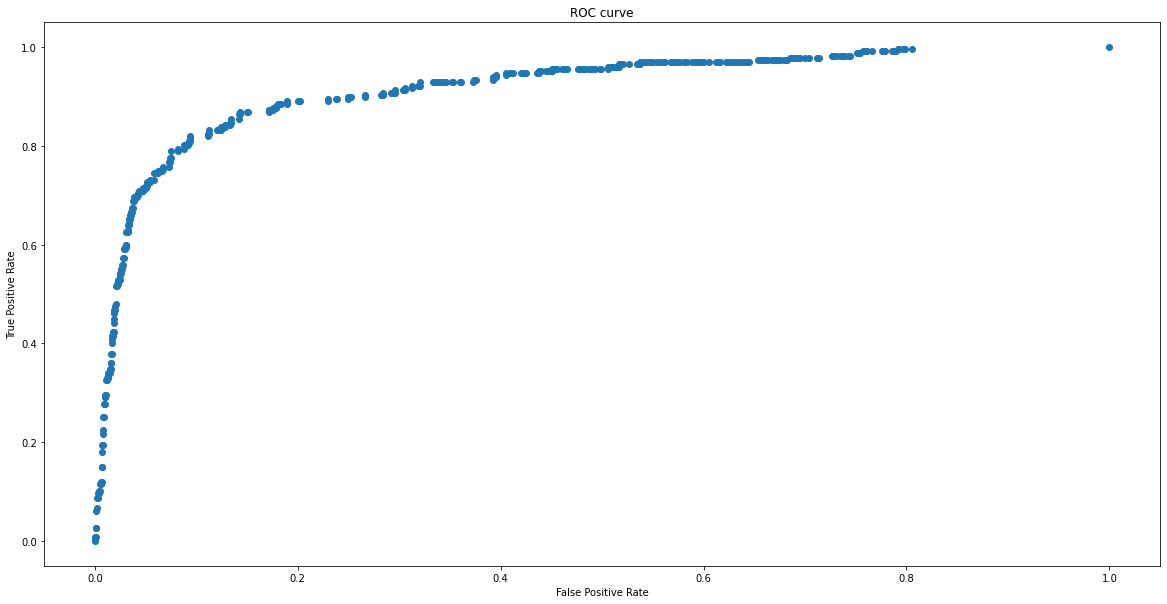

ROC_AUC_Score 0.7905887658662205


In [68]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

# Figure: ROC_AUC_graph
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


print('ROC_AUC_Score', roc_auc_score(y_val, y_pred))

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)


print('Best hyperparameters: ', search.best_params_)
print('Cross-validation Accuracy: ', search.best_score_)

Best hyperparameters:  {'simpleimputer__strategy': 'most_frequent', 'selectkbest__k': 10, 'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 25, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__max_depth': 32, 'randomforestclassifier__criterion': 'entropy'}
Cross-validation Accuracy:  0.9043386243386244
ROC_AUC_Score 0.7905887658662205
F-1 Score:  0.6813725490196079


game_pk
batter
inning
top_bottom
description
at_bat_event
opponent
pitch_category
pitch_type_code
call_code


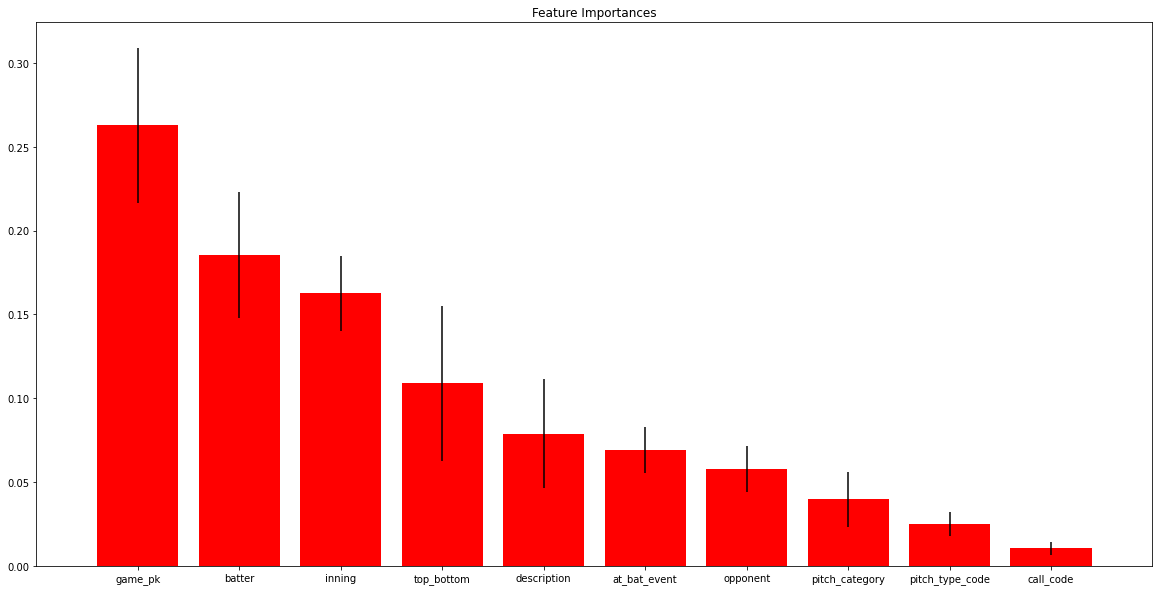

In [42]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = rf.feature_importances_

# define standard deviation for graph
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature rank
for f in range(len(indices)):
    print(X.columns[indices][f])
# Plot feature importances
plt.figure()
plt.rcParams["figure.figsize"] = (20, 10)
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color='red', yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices])
plt.xlim([-1, len(indices)])
plt.show()

In [70]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=50, random_state=17, n_jobs=-1, scale_pos_weight=),
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['opponent', 'top_bottom', 'batter',
                                      'at_bat_event', 'pitch_type_code',
                                      'pitch_category', 'call_code',
                                      'description'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'opponent',
                                          'data_type': dtype('O'),
                                          'mapping': BAL     1
DET     2
TOR     3
TEX     4
OAK     5
CLE     6
ANA     7
ARI     8
SEA     9
MIN    10
TB     11
N...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                           

In [0]:
param_distributions = {
    'selectkbest__k': [10],
    'simpleimputer__strategy': ['most_frequent'],
}

In [77]:
y_pred = pipeline.predict(X_val)
#print('Accuracy Score: ', pipeline.score(X_val, y_val))
print('Accuracy Score: ', accuracy_score(y_val, y_pred))
print('F-1 Score: ', f1_score(y_val, y_pred))

Accuracy Score:  0.9123809523809524
F-1 Score:  0.655
